In [1]:
import numpy as np, os, sys
sys.path.append("..")
import pandas as pd
import subprocess

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data
from src.models import DeepBindCNN
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from src.utils import metrics
from src.explain import Explainer

from logomaker import Logo

import matplotlib as mpl 
from matplotlib import pyplot as plt 
import seaborn as sns 
%matplotlib inline

In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [5]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])
    
# set up the model, lossfn, optimizer, trainer 
model = DeepBindCNN(input_size=4, output_size=1, kernel_size=9)
lossfn = nn.CrossEntropyLoss()

model.load_state_dict(torch.load('best_model.pt'))
print(model)

DeepBindCNN(
  (conv1): Conv1d(4, 16, kernel_size=(9,), stride=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [6]:
# model 
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [7]:
# get explainer instance
explainer = Explainer(model)

## Saliency Map

In [10]:
# load ground truth
gt_test = np.load("./data/gt_test.npy")

In [11]:
def visualize_saliency_scores(saliency_score, gt):
    df = pd.DataFrame(saliency_score, columns=list("ACGT"))

    # visualize saliency scores 
    fig = plt.figure(figsize=(12, 3.5))
    ax = fig.add_subplot(211)
    _= Logo(df, ax=ax)

    # calculate gt information 
    w = gt.T
    I  = np.log2(4) + np.sum(w * np.log2(w+1e-10), axis=1, keepdims=True)

    # visualize the gt information
    df = pd.DataFrame(I*w, columns=list("ACGT"))
    ax = fig.add_subplot(212)
    _= Logo(df, ax=ax)

In [12]:
## get saliency score of a random test sample

# Select a random sample from the test dataset
sample_index = np.random.randint(len(datasets['test']))
input_sequence, target_label = datasets['test'][sample_index]
print(input_sequence.shape)
saliency_score = explainer.saliency_map(input_sequence.unsqueeze(0))
saliency_score = saliency_score.abs().detach().cpu().numpy()[0].T

print(saliency_score.shape)

torch.Size([4, 200])
(200, 4)


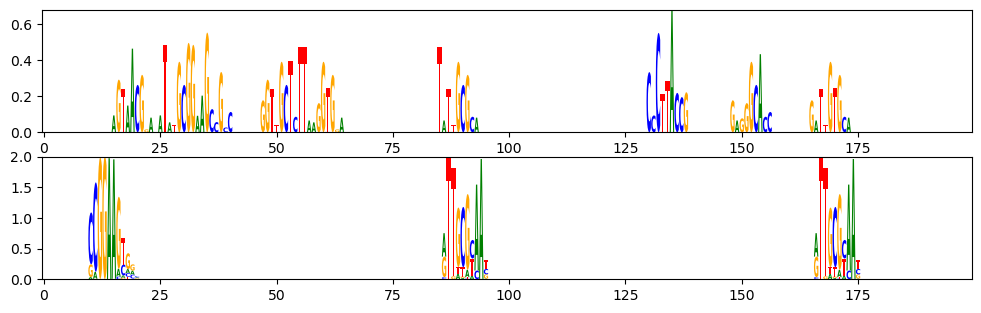

In [33]:
visualize_saliency_scores(saliency_score, gt_test[sample_index])

In [17]:
# get saliency score of complete test dataset

saliency_scores = []
for input_sequence, target_label in loaders['test']:
    input_sequence, target_label = input_sequence.to(device), target_label.to(device)
    saliency_score = explainer.saliency_map(input_sequence)
    saliency_score = saliency_score.abs().detach().cpu().numpy()[0].T
    saliency_scores.append(saliency_score)

In [38]:
print(len(saliency_scores), saliency_scores[0].shape)

125 (200, 4)


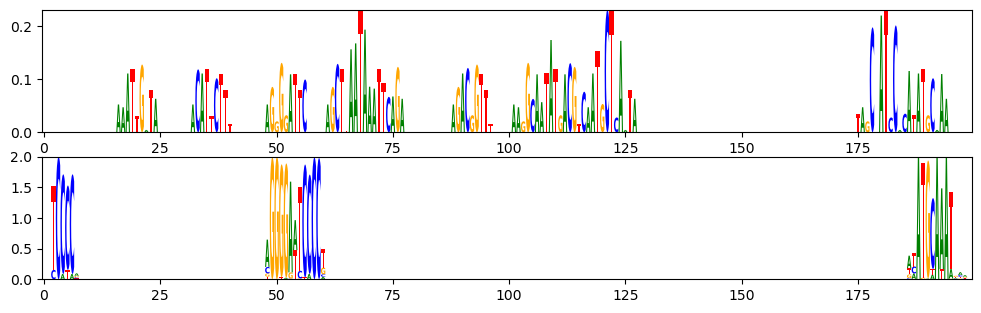

In [15]:
visualize_saliency_scores(saliency_scores[0], gt_test[0])

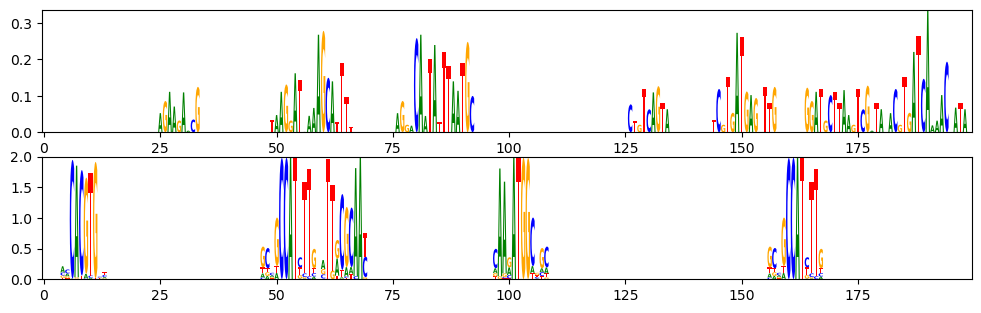

In [16]:
visualize_saliency_scores(saliency_scores[1], gt_test[1])

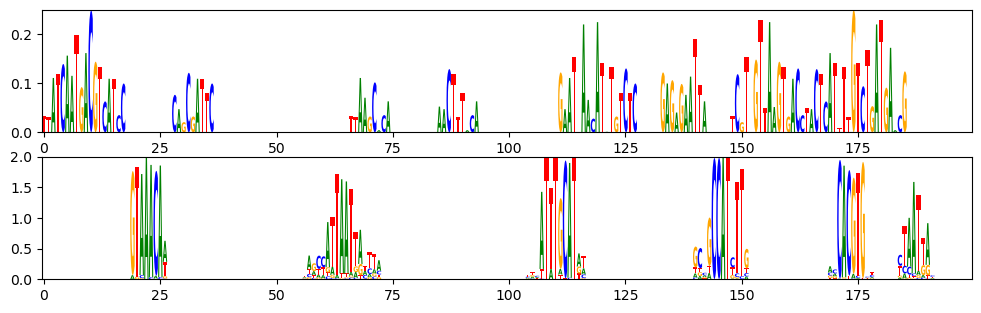

In [18]:
visualize_saliency_scores(saliency_scores[2], gt_test[2])

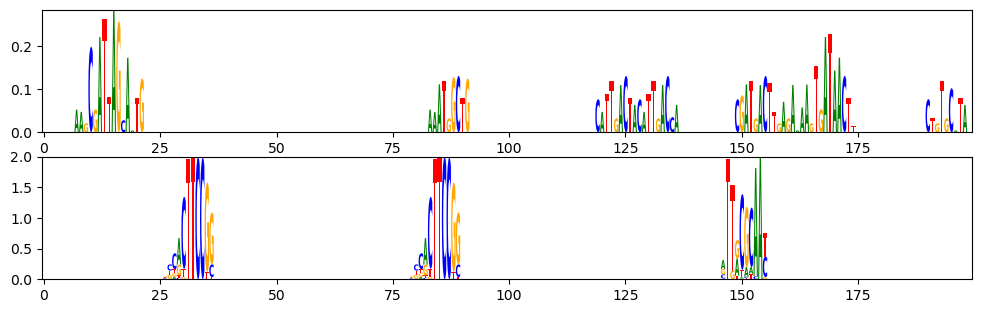

In [19]:
visualize_saliency_scores(saliency_scores[100], gt_test[100])

## SmoothGrad

In [9]:
saliency_scores = []
for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    print(inputs.shape) # [batch_size, channels, seq_len]
    saliency_scores.append(explainer.smoothgrad(inputs))
print(saliency_scores[0])

torch.Size([32, 4, 200])


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [50, 32, 4, 200]

## Integrated Gradients

In [6]:
saliency_scores = []
for inputs, labels in loaders['test']:
    inputs, labels = inputs.to(device), labels.to(device)
    saliency_scores.append(explainer.integrated_gradients(inputs))


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [50, 32, 4, 200]